<a href="https://colab.research.google.com/github/COAP230023/atividade-praticas-em-numpy-RafaelYuta/blob/main/RAFAEL_YUTA_NOGAMI_NAKAYAMA_atividade_hough_circles_numpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Atividade: Detectando círculos com a Transformada de Hough

Nesta atividade, vamos construir **na mão** uma versão simplificada da Transformada de Hough para detectar círculos em imagens.

Vamos usar apenas:
- `numpy` para o processamento numérico;
- `matplotlib` apenas para carregar e visualizar as imagens.



## Preparação: carregando e visualizando a imagem

Use uma imagem contendo alguns objetos aproximadamente circulares (por exemplo, **moedas em cima de uma folha de papel**).

- Substitua o nome do arquivo `"moedas.png"` pela imagem que você quiser testar.
- A imagem pode estar em formato PNG/JPG.


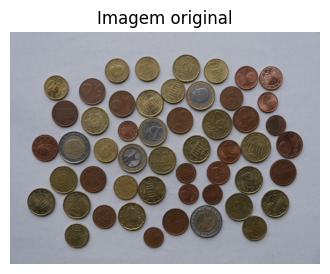

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# TODO: troque o nome do arquivo aqui, se necessário
img = plt.imread("moedas.jpg")  # ex.: moedas em fundo claro

plt.figure(figsize=(4, 4))
if img.ndim == 3:
    plt.imshow(img)
else:
    plt.imshow(img, cmap="gray")
plt.title("Imagem original")
plt.axis("off")
plt.show()

## 1. De RGB para tons de cinza

Se a imagem tiver 3 canais (RGB), vamos convertê-la para tons de cinza usando uma combinação ponderada dos canais.

> Lembrete: usamos pesos diferentes para R, G e B porque o olho humano é mais sensível ao verde.


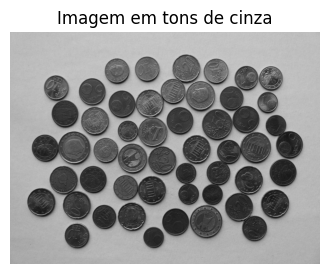

In [10]:
# TODO: Transformas a imagem em tons de cinza.
channels_same_weight = [.33, .33, .33]
img_gray = np.sum(img * channels_same_weight, axis=2)
plt.figure(figsize=(4, 4))
plt.imshow(img_gray, cmap="gray")
plt.title("Imagem em tons de cinza")
plt.axis("off")
plt.show()

## 2. Recap: detecção de bordas (Sobel)

Antes de usar a Transformada de Hough, precisamos de **bordas**.
Aqui vamos usar:

1. Um **blur de média** para suavizar a imagem e reduzir ruído.
2. O operador de **Sobel** para obter o gradiente em x e y.
3. A magnitude do gradiente + limiar para obter uma imagem **binária de bordas**.


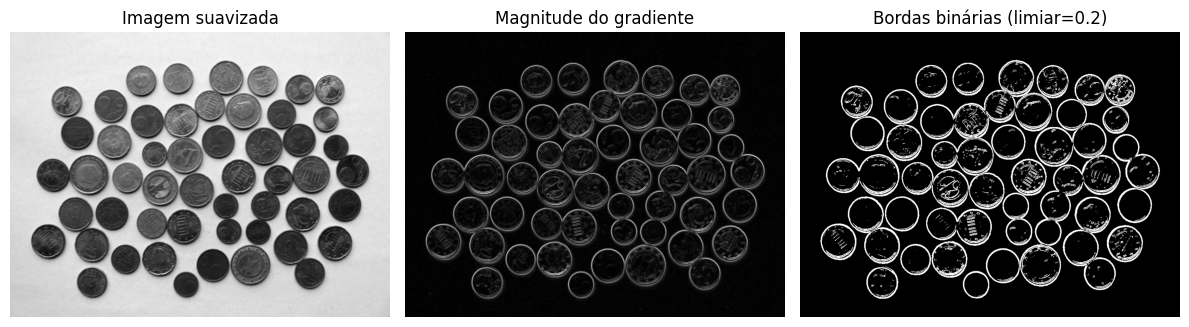

In [11]:
def convolve2d(img, kernel):
    """Convolução 2D simples (modo 'same') com padding de borda.
    img: array 2D
    kernel: array 2D (ex.: 3x3)
    """
    img = img.astype(float)
    kh, kw = kernel.shape
    pad_h, pad_w = kh // 2, kw // 2

    padded = np.pad(img,
                    pad_width=((pad_h, pad_h), (pad_w, pad_w)),
                    mode="edge")

    out = np.zeros_like(img, dtype=float)

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            regiao = padded[i:i+kh, j:j+kw]
            out[i, j] = np.sum(regiao * kernel)

    return out

# Blur
# TODO: Aplicar o kernel de blur na imagem

def mean_kernel(size):
    k = np.ones((size, size), dtype=float)
    k /= k.size
    return k

K_mean_3 = mean_kernel(3)
blur_mean_3 = convolve2d(img_gray, K_mean_3)

# Operador de Sobel
sobel_x = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
], dtype=float)

sobel_y = np.array([
    [-1, -2, -1],
    [ 0,  0,  0],
    [ 1,  2,  1]
], dtype=float)

Gx = convolve2d(blur_mean_3, sobel_x)
Gy = convolve2d(blur_mean_3, sobel_y)
magnitude = np.sqrt(Gx**2 + Gy**2)
magnitude_norm = magnitude / (magnitude.max() + 1e-8)

# TODO: experimente valores diferentes de limiar (entre 0 e 1)
limiar = 0.2
edges_bin = (magnitude_norm > limiar).astype(np.uint8)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(blur_mean_3, cmap="gray")
plt.title("Imagem suavizada")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(magnitude_norm, cmap="gray")
plt.title("Magnitude do gradiente")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(edges_bin, cmap="gray")
plt.title(f"Bordas binárias (limiar={limiar})")
plt.axis("off")

plt.tight_layout()
plt.show()

1. As bordas binárias destacam bem os contornos das moedas (ou círculos) na imagem?

> Sim, quanto menor a variável limiar, mais destacado as bordas ficam


## 3. Ideia da Transformada de Hough para círculos

Um círculo com centro $(a, b)$ e raio $r$ satisfaz:

$$
(x - a)^2 + (y - b)^2 = r^2
$$

Para um **pixel de borda** $(x, y)$ e um raio fixo $r$:

- Todos os possíveis centros $(a, b)$ de círculos de raio $r$ que passam por $(x, y)$ formam um **círculo** em torno de $(x, y)$.
- Na Transformada de Hough, fazemos o pixel de borda “votar” em vários centros $(a, b)$ ao longo desse círculo.
- Repetimos isso para **todos os pixels de borda**.
- Onde muitos votos se acumulam, temos um forte candidato a **centro de um círculo**.

Nesta primeira versão, vamos assumir que o **raio é conhecido** (ou aproximado). Isso simplifica bastante o código e a compreensão.


## 4. Hough para círculos com raio fixo

Vamos implementar uma função `hough_circles_fixed_radius` que:

1. Recebe uma imagem de bordas binária (`edges`).
2. Recebe um raio \( r \) (em pixels).
3. Para cada pixel de borda, faz votos em possíveis centros.
4. Devolve um **acumulador 2D** `acc[b, a]` com o número de votos para cada centro.


In [12]:
def hough_circles_fixed_radius(edges, r, num_angles=360):
    """Transformada de Hough para círculos com raio fixo.

    edges: imagem binária (0 ou 1) com bordas
    r: raio (em pixels)
    num_angles: quantos ângulos entre 0 e 2π usar

    Retorna: acumulador 2D (altura x largura) com votos de centros.
    """
    h, w = edges.shape

    thetas = np.linspace(0, 2*np.pi, num_angles, endpoint=False)
    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)

    acc = np.zeros((h, w), dtype=np.uint64)

    # Coordenadas dos pixels de borda (valor 1)
    ys, xs = np.nonzero(edges)  # y = linha, x = coluna

    for x, y in zip(xs, ys):
        # Todos os possíveis centros (a, b) para este pixel, dado o raio r
        a = x - r * cos_t
        b = y - r * sin_t

        a_round = np.round(a).astype(int)
        b_round = np.round(b).astype(int)

        # Mantém apenas centros que caem dentro dos limites da imagem
        valid = (
            (a_round >= 0) & (a_round < w) &
            (b_round >= 0) & (b_round < h)
        )

        a_valid = a_round[valid]
        b_valid = b_round[valid]

        # Votar nesses centros
        acc[b_valid, a_valid] += 1

    return acc

### 4.1. Executando o Hough com um raio estimado

- Escolha um raio aproximado (em pixels) para os círculos da sua imagem.
- Você pode usar um valor inicial e ajustar olhando o resultado.


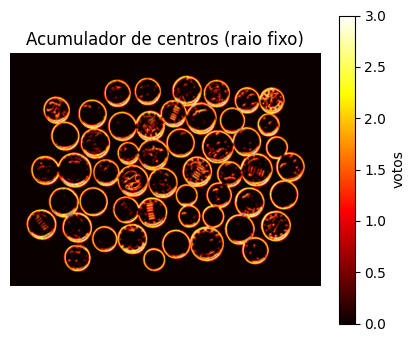

Máximo de votos no acumulador: 3


In [18]:
# TODO: ajuste este valor conforme o tamanho dos círculos na sua imagem
r_est = 2  # raio estimado (em pixels)

acc = hough_circles_fixed_radius(edges_bin, r_est, num_angles=3)

plt.figure(figsize=(5, 4))
plt.imshow(acc, cmap="hot")
plt.title("Acumulador de centros (raio fixo)")
plt.colorbar(label="votos")
plt.axis("off")
plt.show()

print("Máximo de votos no acumulador:", acc.max())

> **Observação:** As regiões mais claras (valores maiores no acumulador) representam pontos que receberam muitos votos,
> ou seja, **prováveis centros de círculos** de raio `r_est`.


## 5. Detectando picos no acumulador e desenhando os círculos

Agora vamos:

1. Definir um **limiar de votos** como fração do valor máximo no acumulador.
2. Considerar todos os pontos acima desse limiar como centros de círculos.
3. Desenhar esses círculos sobre a imagem original.


Círculos detectados: 19167
Centro (x, y) e raio: (np.int64(583), np.int64(77), 2)
Centro (x, y) e raio: (np.int64(584), np.int64(77), 2)
Centro (x, y) e raio: (np.int64(585), np.int64(77), 2)
Centro (x, y) e raio: (np.int64(574), np.int64(78), 2)
Centro (x, y) e raio: (np.int64(590), np.int64(78), 2)
Centro (x, y) e raio: (np.int64(570), np.int64(79), 2)
Centro (x, y) e raio: (np.int64(578), np.int64(79), 2)
Centro (x, y) e raio: (np.int64(579), np.int64(79), 2)
Centro (x, y) e raio: (np.int64(584), np.int64(79), 2)
Centro (x, y) e raio: (np.int64(585), np.int64(79), 2)
Centro (x, y) e raio: (np.int64(586), np.int64(79), 2)
Centro (x, y) e raio: (np.int64(587), np.int64(79), 2)
Centro (x, y) e raio: (np.int64(588), np.int64(79), 2)
Centro (x, y) e raio: (np.int64(594), np.int64(79), 2)
Centro (x, y) e raio: (np.int64(587), np.int64(80), 2)
Centro (x, y) e raio: (np.int64(588), np.int64(80), 2)
Centro (x, y) e raio: (np.int64(589), np.int64(80), 2)
Centro (x, y) e raio: (np.int64(590), 

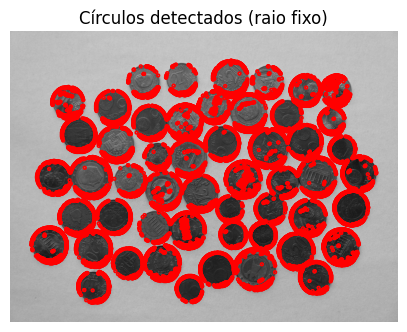

In [19]:
def detectar_circulos_raio_fixo(acc, r, frac_limiar=0.7):
    """Detecta círculos em um acumulador de raio fixo.

    acc: acumulador 2D (altura x largura)
    r: raio (em pixels)
    frac_limiar: fração do valor máximo para definir o limiar de votos

    Retorna: lista de círculos (x_centro, y_centro, r)
    """
    max_votes = acc.max()
    limiar = max_votes * frac_limiar

    ys, xs = np.where(acc >= limiar)

    circles = []
    for y, x in zip(ys, xs):
        circles.append((x, y, r))

    return circles

# TODO: experimente outras frações de limiar (0.5, 0.6, 0.8...)
circles = detectar_circulos_raio_fixo(acc, r_est, frac_limiar=0.7)
print("Círculos detectados:", len(circles))
for c in circles:
    print("Centro (x, y) e raio:", c)

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(img_gray, cmap="gray")

for (x0, y0, r) in circles:
    # Desenha o círculo em vermelho
    circ = plt.Circle((x0, y0), r, fill=False, edgecolor="red", linewidth=2)
    ax.add_patch(circ)

ax.set_title("Círculos detectados (raio fixo)")
ax.axis("off")
plt.show()

###

2. O número de círculos detectados faz sentido ao olhar a imagem?

> Não

3. O que acontece se você:
   - Mudar o valor de `r_est` (raio estimado)?
   - Mudar `frac_limiar` (fração do máximo no acumulador)?
   - Mudar `num_angles` na função de Hough (mais ou menos ângulos)?

> Ao mudar o valor de r_est as bordas dos circulos aumentam baseado no quão alto o número é. Ao mudar o número de frac_limiar o sistema de detectar circulos fica menos rigoroso, reconhecendo menos pontos como circulos. Ao mudar o num_angles a variação de cor diminui, deixando a imagem com cores menos detalhadas

4. Quais as limitações do que realizamos até aqui? Como podemos melhorar?

> O sistema consegue circular as moedas porém não consegue mostrar o número real de moedas mostrando apenas um número extremamente elevado que não condiz com a realidade.
